# Callisto Test Generation for MNIST-Digit

### Dependencies
* Python 3
* Keras
* Tensorflow
* Random
* Pickle
* Math
* Matplotlib
* OpenCV
* h5py

In [29]:
import tensorflow.keras as keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import math
import cv2
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix
from keras.models import Model
import _pickle as pickle
import copy
import random
import tensorflow as tf

### Please download the pre-trained MNIST model [here](https://drive.google.com/file/d/1bT3ksg_C61kdDtqTDB0-c-5DqYS1D__1/view?usp=sharing) and save it in the "models" folder under MNIST-Digit

### MD5 checksum = 9e642043e426595909f3227d1d27646e

In [64]:
model1_file = "../models/MNIST.h5py"

#### Please change 'MINI_DATASET_TEST' to False if you want to run the full MNIST dataset. Once it is set to true, the test generation framework will only run for a subset images in the interest of time. 

In [38]:
MINI_DATASET_TEST = True
MINI_DATASET_N = 1000

In [39]:
#Importing the training and testing data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train= x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

#Converting the labels to a categorical form
y_train=to_categorical(y_train, num_classes=10)
y_test=to_categorical(y_test, num_classes=10)

if MINI_DATASET_TEST:
    x_train = x_train[:MINI_DATASET_N]
    x_test = x_test[:MINI_DATASET_N]
    y_train = y_train[:MINI_DATASET_N]
    y_test = y_test[:MINI_DATASET_N]

In [40]:
#Model architechture
model1=Sequential()
model1.add(Conv2D(8, kernel_size=(3, 3), strides=(1, 1),padding="same",
                 kernel_initializer='random_uniform',
                bias_initializer='random_uniform',
                 activation='relu',input_shape=[28,28,1]))
model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="valid"))
model1.add(Conv2D(16,kernel_size=(3,3),strides=(1,1),padding="same",
                kernel_initializer='random_uniform',
                bias_initializer='random_uniform',
                activation="relu"))
model1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="valid"))
model1.add(Flatten())
model1.add(Dense(100,activation="relu",kernel_initializer='random_uniform',
                bias_initializer='zeros'))
model1.add(Dense(10,activation="softmax",kernel_initializer='random_uniform',
                bias_initializer='zeros'))

In [41]:
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
model1.load_weights(model1_file)

In [43]:
test_loss, test_acc = model1.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

1000/1000 [==============================] - 0s 99us/step
Test accuracy: 0.9829999804496765


In [44]:
layer_outputs = [layer.output for layer in model1.layers]

activation_model = Model(inputs=model1.input, outputs=layer_outputs)

### all_train_acts.pickle contains all the activations of the training data. This is necesscary for Callisto to calculate the shannon indices of the image input. Please download the file [here](https://drive.google.com/file/d/1xyoIpkv-L0SxMyxGnkSZzBd2JkiqTVJi/view?usp=sharing). The file should be saved in the "saved_pickles" folder  MNIST-Digit

### MD5 checksum = 9a7463549e6301c694759436d3c8010b

In [45]:
with open('../saved_pickles/all_train_acts.pickle', 'rb') as handle: 
     all_acts = pickle.load(handle)
        
if MINI_DATASET_TEST:
    all_acts = all_acts[:MINI_DATASET_N]

In [46]:
def shannon(arrs):
    shannons = []
    for arr in arrs:
        sum = 0
        for i in arr:
            sum += (i*np.log(i))
        shannons.append(sum * -1.0)
    return shannons

In [47]:
all_shannons = shannon(all_acts)

In [48]:
low_shannon_true = []
for i in range(len(all_shannons)):
    if all_shannons[i] < 0.001 and np.argmax(all_acts[i]) == np.argmax(y_train[i]) : 
        low_shannon_true.append(i)
        
print("low_shannon_true:", len(low_shannon_true))

low_shannon_true: 823


In [49]:
rows,cols = (28, 28)
M = np.float32([[1,0,2],[0,1,2]])

Original Image


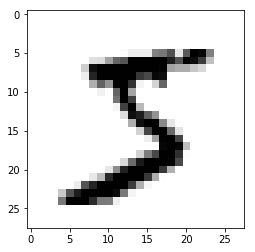

In [50]:
print("Original Image")
img = x_train[0]
label = y_train[0]
plt.imshow(img.reshape(28,28), cmap=plt.cm.binary)
plt.show()

In [51]:
# Panning Transformation in openCV
rows,cols = (28, 28)
M = np.float32([[1,0,2],[0,1,2]])

Transformation: Panning


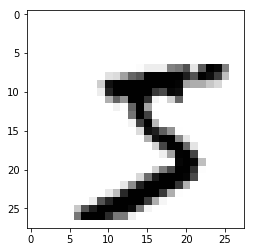

In [52]:
print("Transformation: Panning")
rows,cols = (28, 28)
M = np.float32([[1,0,2],[0,1,2]])
dst = cv2.warpAffine(img,M,(cols,rows))
plt.imshow(dst, cmap=plt.cm.binary)
plt.show()

In [53]:
print("Transformation: Panning")
cols,rows = 28, 28
count_made_false_low_shannon_true = 0
for i in low_shannon_true:
    img = x_train[i]
    label = y_train[i]
    img = (np.expand_dims(img,0))
    img_pred = activation_model.predict(img)[6][0]
    
    dst = cv2.warpAffine(x_train[i],M,(28,28)).reshape(28,28,1)
    dst = (np.expand_dims(dst,0))
    dst_pred = activation_model.predict(dst)[6][0]
    
    if (np.argmax(img_pred) != np.argmax(dst_pred)):
        count_made_false_low_shannon_true += 1


print("Shannon Treshold : < 0.001")        
print("Number of inputs: ", len(low_shannon_true))        
print("Error Rate: ", (count_made_false_low_shannon_true*1.0)/len(low_shannon_true))

Transformation: Panning
Shannon Treshold : < 0.001
Number of inputs:  823
Error Rate:  0.2235722964763062


In [54]:
print("Transformation: Panning")
thresholds = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for threshold in thresholds:
    high_shannon_true = []
    for i, shannon_index in enumerate(all_shannons):
        if shannon_index > threshold and (np.argmax(all_acts[i]) == np.argmax(y_train[i])) : 
            high_shannon_true.append(i)

    print("Shannon Treshold : >", threshold)
    print("Number of inputs: ", len(high_shannon_true))

    count_made_false_high_shannon_true = 0
    
    if len(high_shannon_true) > 0:
        for i in high_shannon_true:
            img = x_train[i]
            label = y_train[i]
            img = (np.expand_dims(img,0))
            img_pred = activation_model.predict(img)[6][0]

            dst = cv2.warpAffine(x_train[i],M,(28,28)).reshape(28,28,1)
            dst = (np.expand_dims(dst,0))
            dst_pred = activation_model.predict(dst)[6][0]
            if (np.argmax(img_pred) != np.argmax(dst_pred)):
                count_made_false_high_shannon_true += 1

        print("Error Rates :", (count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
        
    else:
        print("No inputs with shannon index more than ", threshold)
        
    print("")

Transformation: Panning
Shannon Treshold : > 0.01
Number of inputs:  87
Error Rates : 0.4827586206896552

Shannon Treshold : > 0.025
Number of inputs:  59
Error Rates : 0.5423728813559322

Shannon Treshold : > 0.05
Number of inputs:  43
Error Rates : 0.627906976744186

Shannon Treshold : > 0.1
Number of inputs:  26
Error Rates : 0.6923076923076923

Shannon Treshold : > 0.2
Number of inputs:  17
Error Rates : 0.7058823529411765

Shannon Treshold : > 0.3
Number of inputs:  12
Error Rates : 0.8333333333333334

Shannon Treshold : > 0.4
Number of inputs:  10
Error Rates : 0.8

Shannon Treshold : > 0.5
Number of inputs:  8
Error Rates : 0.75

Shannon Treshold : > 0.6
Number of inputs:  5
Error Rates : 0.6

Shannon Treshold : > 0.7
Number of inputs:  3
Error Rates : 0.3333333333333333

Shannon Treshold : > 0.8
Number of inputs:  2
Error Rates : 0.5

Shannon Treshold : > 0.9
Number of inputs:  0
No inputs with shannon index more than  0.9

Shannon Treshold : > 1.0
Number of inputs:  0
No input

Transformation: 2D rotation


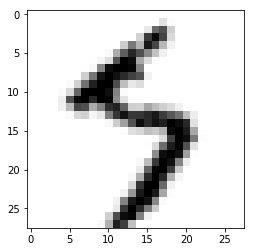

In [55]:
print("Transformation: 2D rotation")
rows,cols = (28, 28)
M = cv2.getRotationMatrix2D((cols/2,rows/2),30,1)
img = x_train[0]
dst = cv2.warpAffine(img,M,(cols,rows))
plt.imshow(dst, cmap=plt.cm.binary)
plt.show()

In [56]:
print("Transformation: Rotation")
cols,rows = 28, 28
count_made_false_low_shannon_true = 0
for i in low_shannon_true:
    img = x_train[i]
    label = y_train[i]
    img = (np.expand_dims(img,0))
    img_pred = activation_model.predict(img)[6][0]
    
    dst = cv2.warpAffine(x_train[i],M,(28,28)).reshape(28,28,1)
    dst = (np.expand_dims(dst,0))
    dst_pred = activation_model.predict(dst)[6][0]
    
    if (np.argmax(img_pred) != np.argmax(dst_pred)):
        count_made_false_low_shannon_true += 1


print("Shannon Treshold : < 0.001")        
print("Number of inputs: ", len(low_shannon_true))        
print("Error Rate: ", (count_made_false_low_shannon_true*1.0)/len(low_shannon_true))

Transformation: Rotation
Shannon Treshold : < 0.001
Number of inputs:  823
Error Rate:  0.09477521263669501


In [57]:
print("Transformation: Rotation")
thresholds = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for threshold in thresholds:
    high_shannon_true = []
    for i, shannon_index in enumerate(all_shannons):
        if shannon_index > threshold and (np.argmax(all_acts[i]) == np.argmax(y_train[i])) : 
            high_shannon_true.append(i)

    print("Shannon Treshold : >", threshold)
    print("Number of inputs: ", len(high_shannon_true))

    count_made_false_high_shannon_true = 0
    
    if len(high_shannon_true) > 0:
        for i in high_shannon_true:
            img = x_train[i]
            label = y_train[i]
            img = (np.expand_dims(img,0))
            img_pred = activation_model.predict(img)[6][0]

            dst = cv2.warpAffine(x_train[i],M,(28,28)).reshape(28,28,1)
            dst = (np.expand_dims(dst,0))
            dst_pred = activation_model.predict(dst)[6][0]
            if (np.argmax(img_pred) != np.argmax(dst_pred)):
                count_made_false_high_shannon_true += 1

        print("Error Rates :", (count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
        
    else:
        print("No inputs with shannon index more than ", threshold)
        
    print("")

Transformation: Rotation
Shannon Treshold : > 0.01
Number of inputs:  87
Error Rates : 0.4367816091954023

Shannon Treshold : > 0.025
Number of inputs:  59
Error Rates : 0.4406779661016949

Shannon Treshold : > 0.05
Number of inputs:  43
Error Rates : 0.46511627906976744

Shannon Treshold : > 0.1
Number of inputs:  26
Error Rates : 0.5

Shannon Treshold : > 0.2
Number of inputs:  17
Error Rates : 0.47058823529411764

Shannon Treshold : > 0.3
Number of inputs:  12
Error Rates : 0.3333333333333333

Shannon Treshold : > 0.4
Number of inputs:  10
Error Rates : 0.4

Shannon Treshold : > 0.5
Number of inputs:  8
Error Rates : 0.5

Shannon Treshold : > 0.6
Number of inputs:  5
Error Rates : 0.4

Shannon Treshold : > 0.7
Number of inputs:  3
Error Rates : 0.6666666666666666

Shannon Treshold : > 0.8
Number of inputs:  2
Error Rates : 1.0

Shannon Treshold : > 0.9
Number of inputs:  0
No inputs with shannon index more than  0.9

Shannon Treshold : > 1.0
Number of inputs:  0
No inputs with shann

Transformation: Affine


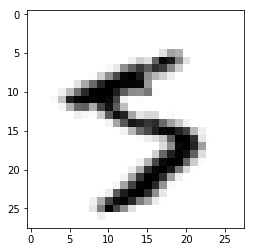

In [58]:
print("Transformation: Affine")
rows,cols = (28, 28)
pts1 = np.float32([[5,5],[24,5],[5,24]])
pts2 = np.float32([[1,10],[20,5],[10,25]])
M = cv2.getAffineTransform(pts1,pts2)
img = x_train[0]
dst = cv2.warpAffine(img,M,(cols,rows))
plt.imshow(dst, cmap=plt.cm.binary)
plt.show()

In [59]:
print("Transformation: Affine")
cols,rows = 28, 28
count_made_false_low_shannon_true = 0
for i in low_shannon_true:
    img = x_train[i]
    label = y_train[i]
    img = (np.expand_dims(img,0))
    img_pred = activation_model.predict(img)[6][0]
    
    dst = cv2.warpAffine(x_train[i],M,(28,28)).reshape(28,28,1)
    dst = (np.expand_dims(dst,0))
    dst_pred = activation_model.predict(dst)[6][0]
    
    if (np.argmax(img_pred) != np.argmax(dst_pred)):
        count_made_false_low_shannon_true += 1


print("Shannon Treshold : < 0.001")        
print("Number of inputs: ", len(low_shannon_true))        
print("Error Rate: ", (count_made_false_low_shannon_true*1.0)/len(low_shannon_true))

Transformation: Affine
Shannon Treshold : < 0.001
Number of inputs:  823
Error Rate:  0.06439854191980558


In [60]:
print("Transformation: Affine")
thresholds = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for threshold in thresholds:
    high_shannon_true = []
    for i, shannon_index in enumerate(all_shannons):
        if shannon_index > threshold and (np.argmax(all_acts[i]) == np.argmax(y_train[i])) : 
            high_shannon_true.append(i)

    print("Shannon Treshold : >", threshold)
    print("Number of inputs: ", len(high_shannon_true))

    count_made_false_high_shannon_true = 0
    
    if len(high_shannon_true) > 0:
        for i in high_shannon_true:
            img = x_train[i]
            label = y_train[i]
            img = (np.expand_dims(img,0))
            img_pred = activation_model.predict(img)[6][0]

            dst = cv2.warpAffine(x_train[i],M,(28,28)).reshape(28,28,1)
            dst = (np.expand_dims(dst,0))
            dst_pred = activation_model.predict(dst)[6][0]
            if (np.argmax(img_pred) != np.argmax(dst_pred)):
                count_made_false_high_shannon_true += 1

        print("Error Rates :", (count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
        
    else:
        print("No inputs with shannon index more than ", threshold)
        
    print("")

Transformation: Affine
Shannon Treshold : > 0.01
Number of inputs:  87
Error Rates : 0.3448275862068966

Shannon Treshold : > 0.025
Number of inputs:  59
Error Rates : 0.423728813559322

Shannon Treshold : > 0.05
Number of inputs:  43
Error Rates : 0.4418604651162791

Shannon Treshold : > 0.1
Number of inputs:  26
Error Rates : 0.5

Shannon Treshold : > 0.2
Number of inputs:  17
Error Rates : 0.5294117647058824

Shannon Treshold : > 0.3
Number of inputs:  12
Error Rates : 0.4166666666666667

Shannon Treshold : > 0.4
Number of inputs:  10
Error Rates : 0.4

Shannon Treshold : > 0.5
Number of inputs:  8
Error Rates : 0.5

Shannon Treshold : > 0.6
Number of inputs:  5
Error Rates : 0.4

Shannon Treshold : > 0.7
Number of inputs:  3
Error Rates : 0.6666666666666666

Shannon Treshold : > 0.8
Number of inputs:  2
Error Rates : 1.0

Shannon Treshold : > 0.9
Number of inputs:  0
No inputs with shannon index more than  0.9

Shannon Treshold : > 1.0
Number of inputs:  0
No inputs with shannon in

Transformation: Perspective


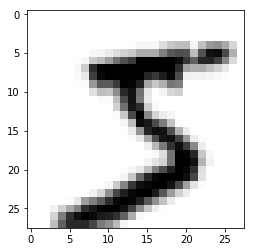

In [61]:
print("Transformation: Perspective")
rows,cols = (28, 28)
pts1 = np.float32([[1,1],[25,1],[1,25],[25,25]])
pts2 = np.float32([[0,0],[28,0],[0,28],[28,28]])
M = cv2.getPerspectiveTransform(pts1,pts2)
img = x_train[0]
dst = cv2.warpPerspective(img,M,(cols,rows))
plt.imshow(dst, cmap=plt.cm.binary)
plt.show()

In [62]:
print("Transformation: Perspective")
cols,rows = 28, 28
count_made_false_low_shannon_true = 0
for i in low_shannon_true:
    img = x_train[i]
    label = y_train[i]
    img = (np.expand_dims(img,0))
    img_pred = activation_model.predict(img)[6][0]
    
    dst = cv2.warpPerspective(x_train[i],M,(28,28)).reshape(28,28,1)
    dst = (np.expand_dims(dst,0))
    dst_pred = activation_model.predict(dst)[6][0]
    
    if (np.argmax(img_pred) != np.argmax(dst_pred)):
        count_made_false_low_shannon_true += 1


print("Shannon Treshold : < 0.001")        
print("Number of inputs: ", len(low_shannon_true))        
print("Error Rate: ", (count_made_false_low_shannon_true*1.0)/len(low_shannon_true))

Transformation: Perspective
Shannon Treshold : < 0.001
Number of inputs:  823
Error Rate:  0.024301336573511544


In [63]:
print("Transformation: Perspective")
thresholds = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for threshold in thresholds:
    high_shannon_true = []
    for i, shannon_index in enumerate(all_shannons):
        if shannon_index > threshold and (np.argmax(all_acts[i]) == np.argmax(y_train[i])) : 
            high_shannon_true.append(i)

    print("Shannon Treshold : >", threshold)
    print("Number of inputs: ", len(high_shannon_true))

    count_made_false_high_shannon_true = 0
    
    if len(high_shannon_true) > 0:
        for i in high_shannon_true:
            img = x_train[i]
            label = y_train[i]
            img = (np.expand_dims(img,0))
            img_pred = activation_model.predict(img)[6][0]

            dst = cv2.warpPerspective(x_train[i],M,(28,28)).reshape(28,28,1)
            dst = (np.expand_dims(dst,0))
            dst_pred = activation_model.predict(dst)[6][0]
            if (np.argmax(img_pred) != np.argmax(dst_pred)):
                count_made_false_high_shannon_true += 1

        print("Error Rates :", (count_made_false_high_shannon_true*1.0)/len(high_shannon_true))
        
    else:
        print("No inputs with shannon index more than ", threshold)
        
    print("")

Transformation: Perspective
Shannon Treshold : > 0.01
Number of inputs:  87
Error Rates : 0.1724137931034483

Shannon Treshold : > 0.025
Number of inputs:  59
Error Rates : 0.1864406779661017

Shannon Treshold : > 0.05
Number of inputs:  43
Error Rates : 0.18604651162790697

Shannon Treshold : > 0.1
Number of inputs:  26
Error Rates : 0.3076923076923077

Shannon Treshold : > 0.2
Number of inputs:  17
Error Rates : 0.4117647058823529

Shannon Treshold : > 0.3
Number of inputs:  12
Error Rates : 0.4166666666666667

Shannon Treshold : > 0.4
Number of inputs:  10
Error Rates : 0.4

Shannon Treshold : > 0.5
Number of inputs:  8
Error Rates : 0.375

Shannon Treshold : > 0.6
Number of inputs:  5
Error Rates : 0.2

Shannon Treshold : > 0.7
Number of inputs:  3
Error Rates : 0.3333333333333333

Shannon Treshold : > 0.8
Number of inputs:  2
Error Rates : 0.5

Shannon Treshold : > 0.9
Number of inputs:  0
No inputs with shannon index more than  0.9

Shannon Treshold : > 1.0
Number of inputs:  0
N